# Lab: Transfer Learning

Welcome to the lab on Transfer Learning! Here, you'll get a chance to try out training a network with ImageNet pre-trained weights as a base, but with additional network layers of your own added on. You'll also get to see the difference between using frozen weights and training on all layers.

### GPU usage
In our previous examples in this lesson, we've avoided using GPU, but this time around you'll have the option to enable it. You do not need it on to begin with, but make sure anytime you switch from non-GPU to GPU, or vice versa, that you save your notebook! If not, you'll likely be reverted to the previous checkpoint. 

We also suggest only using the GPU when performing the (mostly minor) training below - you'll want to conserve GPU hours for your Behavioral Cloning project coming up next!

In [1]:
# Set a couple flags for training - you can ignore these for now
freeze_flag = True  # `True` to freeze layers, `False` for full training
weights_flag = 'imagenet' # 'imagenet' or None
preprocess_flag = True # Should be true for ImageNet pre-trained typically

# Loads in InceptionV3
from keras.applications.inception_v3 import InceptionV3

# We can use smaller than the default 299x299x3 input for InceptionV3
# which will speed up training. Keras v2.0.9 supports down to 139x139x3
input_size = 139

# Using Inception with ImageNet pre-trained weights
inception = InceptionV3(weights=weights_flag, include_top=False,
                        input_shape=(input_size,input_size,3))

Using TensorFlow backend.


87916544/87910968 [==============================] - 1s 0us/step


We'll use Inception V3 for this lab, although you can use the same techniques with any of the models in [Keras Applications](https://keras.io/applications/). Do note that certain models are only available in certain versions of Keras; this workspace uses Keras v2.0.9, for which you can see the available models [here](https://faroit.github.io/keras-docs/2.0.9/applications/).

In the above, we've set Inception to use an `input_shape` of 139x139x3 instead of the default 299x299x3. This will help us to speed up our training a bit later (and we'll actually be upsampling from smaller images, so we aren't losing data here). In order to do so, we also must set `include_top` to `False`, which means the final fully-connected layer with 1,000 nodes for each ImageNet class is dropped, as well as a Global Average Pooling layer.

### Pre-trained with frozen weights
To start, we'll see how an ImageNet pre-trained model with all weights frozen in the InceptionV3 model performs. We will also drop the end layer and append new layers onto it, although you could do this in different ways (not drop the end and add new layers, drop more layers than we will here, etc.).

You can freeze layers by setting `layer.trainable` to False for a given `layer`. Within a `model`, you can get the list of layers with `model.layers`.

In [2]:
if freeze_flag == True:
    ## TODO: Iterate through the layers of the Inception model
    ##       loaded above and set all of them to have trainable = False
    layers = inception.layers
    for i in range(len(layers)):
        layers[i].trainable = False
    print('All {} layer weights frozen'.format(len(layers)))

All 311 layer weights frozen


### Dropping layers
You can drop layers from a model with `model.layers.pop()`. Before you do this, you should check out what the actual layers of the model are with Keras's `.summary()` function.

In [3]:
## TODO: Use the model summary function to see all layers in the
##       loaded Inception model
print(inception.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 139, 139, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 69, 69, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 69, 69, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 69, 69, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In a normal Inception network, you would see from the model summary that the last two layers were a global average pooling layer, and a fully-connected "Dense" layer. However, since we set `include_top` to `False`, both of these get dropped. If you otherwise wanted to drop additional layers, you would use:

```
inception.layers.pop()
```

Note that `pop()` works from the end of the model backwards.

It's important to note two things here:
1. How many layers you drop is up to you, typically. We dropped the final two already by setting `include_top` to False in the original loading of the model, but you could instead just run `pop()` twice to achieve similar results. (*Note:* Keras requires us to set `include_top` to False in order to change the `input_shape`.) Additional layers could be dropped by additional calls to `pop()`.
2. If you make a mistake with `pop()`, you'll want to reload the model. If you use it multiple times, the model will continue to drop more and more layers, so you may need to check `model.summary()` again to check your work.

### Adding new layers

Now, you can start to add your own layers. While we've used Keras's `Sequential` model before for simplicity, we'll actually use the [Model API](https://keras.io/models/model/) this time. This functions a little differently, in that instead of using `model.add()`, you explicitly tell the model which previous layer to attach to the current layer. This is useful if you want to use more advanced concepts like [skip layers](https://en.wikipedia.org/wiki/Residual_neural_network), for instance (which were used heavily in ResNet).

For example, if you had a previous layer named `inp`:
```
x = Dropout(0.2)(inp)
```
is how you would attach a new dropout layer `x`, with it's input coming from a layer with the variable name `inp`.

We are going to use the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html), which consists of 60,000 32x32 images of 10 classes. We need to use Keras's `Input` function to do so, and then we want to re-size the images up to the `input_size` we specified earlier (139x139).

In [4]:
from keras.layers import Input, Lambda
import tensorflow as tf

# Makes the input placeholder layer 32x32x3 for CIFAR-10
cifar_input = Input(shape=(32,32,3))

# Re-sizes the input with Kera's Lambda layer & attach to cifar_input
resized_input = Lambda(lambda image: tf.image.resize_images( 
    image, (input_size, input_size)))(cifar_input)

# Feeds the re-sized input into Inception model
# You will need to update the model name if you changed it earlier!
inp = inception(resized_input)

In [5]:
# Imports fully-connected "Dense" layers & Global Average Pooling
from keras.layers import Dense, GlobalAveragePooling2D

## TODO: Setting `include_top` to False earlier also removed the
##       GlobalAveragePooling2D layer, but we still want it.
##       Add it here, and make sure to connect it to the end of Inception
x = GlobalAveragePooling2D()(inp)

## TODO: Create two new fully-connected layers using the Model API
##       format discussed above. The first layer should use `out`
##       as its input, along with ReLU activation. You can choose
##       how many nodes it has, although 512 or less is a good idea.
##       The second layer should take this first layer as input, and
##       be named "predictions", with Softmax activation and 
##       10 nodes, as we'll be using the CIFAR10 dataset.
x=Dense(512,activation='relu')(x)
predictions=Dense(10,activation='softmax')(x)

We're almost done with our new model! Now we just need to use the actual Model API to create the full model.

In [6]:
# Imports the Model API
from keras.models import Model

# Creates the model, assuming your final layer is named "predictions"
model = Model(inputs=cifar_input, outputs=predictions)

# Compile the model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Check the summary of this new model to confirm the architecture
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 139, 139, 3)       0         
_________________________________________________________________
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 22,857,002
Trainable params: 1,054,218
Non-trainable params: 21,802,784
________________________________________________________

Great job creating a new model architecture from Inception! Notice how this method of adding layers before InceptionV3 and appending to the end of it made InceptionV3 condense down into one line in the summary; if you use the Inception model's normal input (which you could gather from `inception.layers.input`), it would instead show all the layers like before.

Most of the rest of the code in the notebook just goes toward loading our data, pre-processing it, and starting our training in Keras, although there's one other good point to make here - Keras callbacks.

### Keras Callbacks
Keras [callbacks](https://keras.io/callbacks/) allow you to gather and store additional information during training, such as the best model, or even stop training early if the validation accuracy has stopped improving. These methods can help to avoid overfitting, or avoid other issues.

There's two key callbacks to mention here, `ModelCheckpoint` and `EarlyStopping`. As the names may suggest, model checkpoint saves down the best model so far based on a given metric, while early stopping will end training before the specified number of epochs if the chosen metric no longer improves after a given amount of time.

To set these callbacks, you could do the following:
```
checkpoint = ModelCheckpoint(filepath=save_path, monitor='val_loss', save_best_only=True)
```
This would save a model to a specified `save_path`, based on validation loss, and only save down the best models. If you set `save_best_only` to `False`, every single epoch will save down another version of the model.
```
stopper = EarlyStopping(monitor='val_acc', min_delta=0.0003, patience=5)
```
This will monitor validation accuracy, and if it has not decreased by more than 0.0003 from the previous best validation accuracy for 5 epochs, training will end early.


You still need to actually feed these callbacks into `fit()` when you train the model (along with all other relevant data to feed into `fit`):
```
model.fit(callbacks=[checkpoint, stopper])
```

## GPU time

The rest of the notebook will give you the code for training, so you can turn on the GPU at this point - but first, **make sure to save your jupyter notebook**. Once the GPU is turned on, it will load whatever your last notebook checkpoint is. 

While we suggest reading through the code below to make sure you understand it, you can otherwise go ahead and select *Cell > Run All* (or *Kernel > Restart & Run All* if already using GPU) to run through all cells in the notebook.

In [7]:
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
from keras.datasets import cifar10

(X_train, y_train), (X_val, y_val) = cifar10.load_data()

# One-hot encode the labels
label_binarizer = LabelBinarizer()
y_one_hot_train = label_binarizer.fit_transform(y_train)
y_one_hot_val = label_binarizer.fit_transform(y_val)

# Shuffle the training & test data
X_train, y_one_hot_train = shuffle(X_train, y_one_hot_train)
X_val, y_one_hot_val = shuffle(X_val, y_one_hot_val)

# We are only going to use the first 10,000 images for speed reasons
# And only the first 2,000 images from the test set
X_train = X_train[:10000]
y_one_hot_train = y_one_hot_train[:10000]
X_val = X_val[:2000]
y_one_hot_val = y_one_hot_val[:2000]

170500096/170498071 [==============================] - 3s 0us/step


You can check out Keras's [ImageDataGenerator documentation](https://faroit.github.io/keras-docs/2.0.9/preprocessing/image/) for more information on the below - you can also add additional image augmentation through this function, although we are skipping that step here so you can potentially explore it in the upcoming project.

In [8]:
# Use a generator to pre-process our images for ImageNet
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input

if preprocess_flag == True:
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
else:
    datagen = ImageDataGenerator()
    val_datagen = ImageDataGenerator()

In [9]:
# Train the model
batch_size = 32
epochs = 5
# Note: we aren't using callbacks here since we only are using 5 epochs to conserve GPU time
model.fit_generator(datagen.flow(X_train, y_one_hot_train, batch_size=batch_size), 
                    steps_per_epoch=len(X_train)/batch_size, epochs=epochs, verbose=1, 
                    validation_data=val_datagen.flow(X_val, y_one_hot_val, batch_size=batch_size),
                    validation_steps=len(X_val)/batch_size)

Epoch 1/5
313/312 [==============================] - 51s 163ms/step - loss: 1.2886 - acc: 0.5687 - val_loss: 0.9030 - val_acc: 0.7180
Epoch 2/5
313/312 [==============================] - 44s 142ms/step - loss: 0.9635 - acc: 0.6691 - val_loss: 0.9498 - val_acc: 0.6900
Epoch 3/5
313/312 [==============================] - 44s 142ms/step - loss: 0.8921 - acc: 0.6943 - val_loss: 0.9054 - val_acc: 0.6975
Epoch 4/5
313/312 [==============================] - 44s 142ms/step - loss: 0.8179 - acc: 0.7214 - val_loss: 0.9029 - val_acc: 0.7145
Epoch 5/5
313/312 [==============================] - 44s 141ms/step - loss: 0.7912 - acc: 0.7230 - val_loss: 0.9993 - val_acc: 0.6965


As you may have noticed, CIFAR-10 is a fairly tough dataset. However, given that we are only training on a small subset of the data, only training for five epochs, and not using any image augmentation, the results are still fairly impressive!

We achieved ~70% validation accuracy here, although your results may vary.

## [Optional] Test without frozen weights, or by training from scratch.

Since the majority of the model was frozen above, training speed is pretty quick. You may also want to check out the training speed, as well as final accuracy, if you don't freeze the weights. Note that this can be fairly slow, so we're marking this as optional in order to conserve GPU time. 

If you do want to see the results from doing so, go back to the first code cell and set `freeze_flag` to `False`. If you want to completely train from scratch without ImageNet pre-trained weights, follow the previous step as well as setting `weights_flag` to `None`. Then, go to *Kernel > Restart & Run All*.

## Comparison

So that you don't use up your GPU time, we've tried out these results ourselves as well.

Training Mode | Val Acc @ 1 epoch | Val Acc @ 5 epoch | Time per epoch
---- | :----: | :----: | ----:
Frozen weights | 65.5% | 70.3% | 50 seconds
Unfrozen weights | 50.6% | 71.6% | 142 seconds
No pre-trained weights | 19.2% | 39.2% | 142 seconds

From the above, we can see that the pre-trained model with frozen weights actually began converging the fastest (already at 65.5% after 1 epoch), while the model re-training from the pre-trained weights slightly edged it out after 5 epochs.

However, this does not tell the whole story - the training accuracy was substantially higher, nearing 87% for the unfrozen weights model. It actually began overfit the data much more under this method. We would likely be able to counteract some of this issue by using data augmentation. On the flip side, the model using frozen weights could also have been improved by actually only freezing a portion of the weights; some of these are likely more specific to ImageNet classes as it gets later in the network, as opposed to the simpler features extracted early in the network.

### The Power of Transfer Learning
Comparing the last line to the other two really shows the power of transfer learning. After five epochs, a model without ImageNet pre-training had only achieved 39.2% accuracy, compared to over 70% for the other two. As such, pre-training the network has saved substantial time, especially given the additional training time needed when the weights are not frozen.

There is also evidence found in various research that pre-training on ImageNet weights will result in a higher overall accuracy than completely training from scratch, even when using a substantially different dataset.

In [1]:
# Read data
import csv
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import Input,Flatten,Dense,Lambda,Cropping2D,Convolution2D,Dropout,MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
import sklearn

# Setting up the model

model = Sequential()
model.add(Lambda(lambda x: x/255.0 - 0.5,input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70,20), (0,0))))
model.add(Convolution2D(24,(5,5),subsample=(2,2),activation='relu'))
model.add(Convolution2D(36,(5,5),subsample=(2,2),activation='relu'))
model.add(Convolution2D(48,(5,5),subsample=(2,2),activation='relu'))
model.add(Convolution2D(64,(3,3),activation='relu'))
model.add(Dropout(0.75))
model.add(Convolution2D(64,(3,3),activation='relu'))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

print(model.summary())

C:\Users\Kishan\Miniconda3\envs\carnd-term1\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\Kishan\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), activation="relu", strides=(2, 2))`
C:\Users\Kishan\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="relu", strides=(2, 2))`
C:\Users\Kishan\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="relu", strides=(2, 2))`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 70, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 158, 24)       1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 77, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 37, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 35, 64)         27712     
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 35, 64)         0         
__________

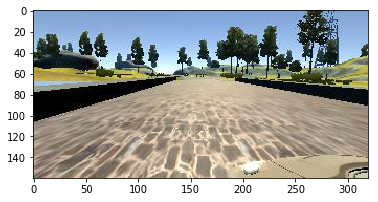

In [14]:
img = plt.imread('data/IMG/left_2016_12_01_13_30_48_287.jpg')
plt.imshow(img)
flipped = np.fliplr(img)
plt.imsave('examples/left_camera.jpg',img)
plt.imsave('examples/left_camera_flipped.jpg',flipped)